In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray
from matplotlib import pyplot as plt
import codebase

In [3]:
res_shp = codebase.load_data.load_GRanD()

In [4]:
from codebase import volume_pipeline

In [5]:
# Step 1 wrapper function works
dem_DA , fw_DA = volume_pipeline.create_aligned_DEM_CYGNSS_subsets('Hoover',res_shp)

In [6]:
# Step 2 function works
fw_diff_DA = volume_pipeline.difference_over_time(fw_DA)

In [7]:
# Step 3 single timestep and vectorized work.
change_cond_DA = volume_pipeline.decide_expansion_or_shrinkage_vectorize(fw_diff_DA)

# Testing out vectorization of Step 3 (label as expand/shrink for each timestep)
test_vectorized = xr.apply_ufunc(volume_pipeline.decide_expansion_or_shrinkage_timestep,
                                 fw_diff_DA,input_core_dims=[['lat','lon']],vectorize=True)

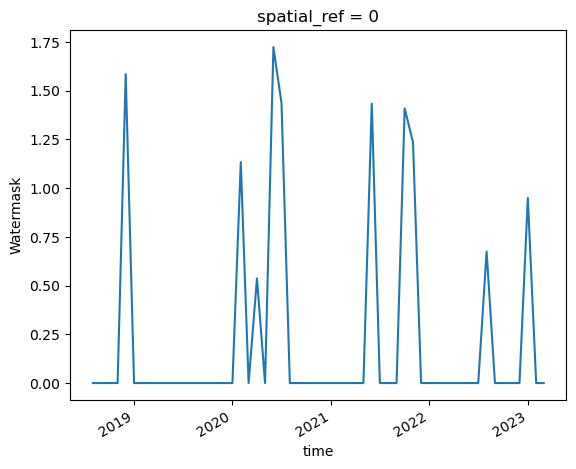

In [8]:
test_vol = volume_pipeline.calculate_rough_volume(dem_DA,fw_DA,fw_diff_DA,change_cond_DA)
test_vol.plot()

In [9]:
# Step 4 wrapper function works
from scipy.stats import norm , loggamma
change_cond_time0 = change_cond_DA.isel(time=0)
fw_diff_time0 = fw_diff_DA.isel(time=0)
fw_time0 = fw_DA.isel(time=0)
start_params = volume_pipeline.fit_DEM_distribution_from_conditional_area(dem_DA, fw_time0, 1, norm)
change_params = volume_pipeline.fit_DEM_distribution_from_conditional_area(dem_DA, fw_diff_time0, change_cond_time0, norm)
print('params of start timestep:',start_params)
print('params of change in area:',change_params)

params of start timestep: (404.7757577828704, 70.5664946396826)
params of change in area: (696.8958890834606, 250.2323373658123)


In [10]:
## Could not vectorize the Step 4 function(s). Skipped vectorization and made for loop functions :(

# from xarray import DataArray
# def grab_DEM_of_conditional_area(
#     dem_DA: DataArray, cond_DA: DataArray, cond: int = 1
# ) -> DataArray:
#     print(type(dem_DA), type(cond_DA) , cond)
#     print(dem_DA.shape)
#     dem_cond_area = dem_DA.where(cond_DA == cond)
#     return dem_cond_area


# xr.apply_ufunc(grab_DEM_of_conditional_area,
#                fw_DA,input_core_dims=[['lat','lon']],kwargs={'dem_DA':dem_DA},
#               vectorize=True, output_core_dims=['time'])

# xr.apply_ufunc(volume_pipeline.fit_DEM_distribution_from_conditional_area,
#                dem_DA,fw_DA[:-1,:,:],change_cond_DA,norm,
#               input_core_dims=[['lat','lon'],['lat','lon'],[],[]],
#               vectorize=True, join='right')

In [11]:
test_params = volume_pipeline.loop_through_time_series_to_get_fit_params(dem_DA,fw_diff_DA,change_cond_DA,norm)

In [12]:
test_heights = volume_pipeline.calculate_height_time_series_from_start_and_change_in_DEM(dem_DA,fw_DA,fw_diff_DA,change_cond_DA)

In [13]:
test_heights

array([ 0.        ,  0.        ,  0.        ,  0.        , 24.54024962,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 17.02561877,  0.        ,
        8.95212975,  0.        , 31.52582711, 22.81487413,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 24.93777225,
        0.        ,  0.        ,  0.        , 28.94449988, 20.5670585 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , 13.91868273,  0.        ,
        0.        ,  0.        ,  0.        , 19.62627224,  0.        ,
        0.        ])

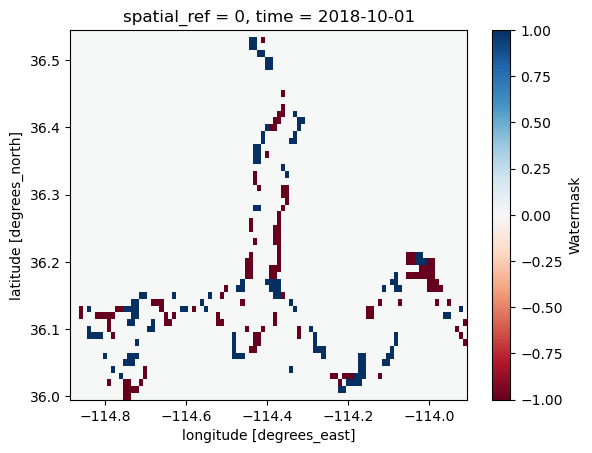

In [14]:
fw_diff_DA.isel(time=1).plot(cmap='RdBu')

In [15]:
test_params[0]

nan

In [16]:
def calculate_rough_area(input_DA):
    """
    Placeholder function while I get the pipeline up and running.
    Should replace with function(s) project into 2D space.
    """
    pixel_count = input_DA.sum()
    area_deg2 = 0.01 *0.01 * pixel_count
    return area_deg2

In [17]:
volume_pipeline.calculate_rough_area_vectorize(fw_DA)

<xarray.DataArray 'Watermask' (time: 57)>
array([0.0632, 0.0702, 0.0693, 0.0665, 0.0646, 0.0764, 0.0679, 0.0715,
       0.0704, 0.0712, 0.0643, 0.0595, 0.0579, 0.0566, 0.0609, 0.0574,
       0.0584, 0.0626, 0.0666, 0.0567, 0.06  , 0.0515, 0.0547, 0.063 ,
       0.0548, 0.0603, 0.0605, 0.0554, 0.0607, 0.0619, 0.0627, 0.0618,
       0.063 , 0.0597, 0.0575, 0.0503, 0.0496, 0.0524, 0.0487, 0.0601,
       0.0525, 0.0549, 0.0514, 0.0543, 0.0548, 0.0528, 0.0516, 0.0539,
       0.0485, 0.0565, 0.0544, 0.0528, 0.0529, 0.0484, 0.0421, 0.0476,
       0.0522])
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2018-08-01 2018-09-01 ... 2023-04-01

In [18]:
test_reproj = fw_DA.rio.reproject("ESRI:54017")

In [19]:
testDA = fw_DA.isel(time=0)
volume_pipeline.project_DA_from_crs_code(testDA,54017)

<xarray.DataArray 'Watermask' (y: 58, x: 96)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)
Coordinates:
  * x            (x) float64 -1.108e+07 -1.108e+07 ... -1.099e+07 -1.099e+07
  * y            (y) float64 4.359e+06 4.358e+06 ... 4.304e+06 4.303e+06
    time         datetime64[ns] 2018-08-01
    spatial_ref  int64 0
Attributes:
    units:     Binary mask of surface water
    comments:  Surface water = 1, ocean/land/no data = 0